# 08. PyTorch Experiment Tracking Exercises

Welcome to the 08. PyTorch Paper Replicating exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/tjpW_BY8y3g) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/).

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cu113
torch version: 2.3.1+cu121
torchvision version: 0.18.1+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

c:\Users\afana\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

Want to download the data we've been using in PyTorch Paper Replicating: https://www.learnpytorch.io/08_pytorch_paper_replicating/#1-get-data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [6]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1fa6f4cf3e0>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

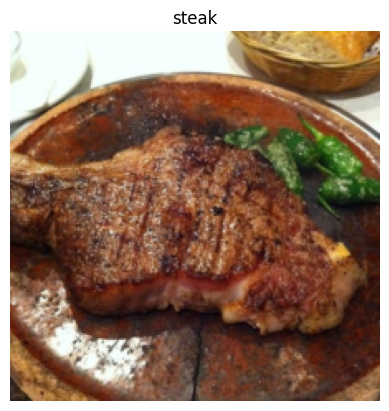

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 1. Replicate the ViT architecture we created with in-built [PyTorch transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).

* You'll want to look into replacing our `TransformerEncoderBlock()` class with [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) (these contain the same layers as our custom blocks).
* You can stack `torch.nn.TransformerEncoderLayer()`'s on top of each other with [`torch.nn.TransformerEncoder()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder).

In [41]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        self.patch_size = patch_size
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [27]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                              nhead=num_heads,
                                                                                              dim_feedforward=mlp_size,
                                                                                              activation="gelu",
                                                                                              batch_first=True,
                                                                                              norm_first=True),
                                                     num_layers=num_transformer_layers) 

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [42]:
img = torch.randn(1, 3, 224, 224).to(device)
print(img.shape) 

summary(model=ViT(num_classes=3),
        input_size=img.shape)

torch.Size([1, 3, 224, 224])


Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 3]                    152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

## 2. Turn the custom ViT architecture we created into a Python script, for example, `vit.py`.

* You should be able to import an entire ViT model using something like`from vit import ViT`.
* We covered the art of turning code cells into Python scrips in [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/).


In [43]:
%%writefile vit.py
import torch
from torch import nn 
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        self.patch_size = patch_size
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                              nhead=num_heads,
                                                                                              dim_feedforward=mlp_size,
                                                                                              activation="gelu",
                                                                                              batch_first=True,
                                                                                              norm_first=True),
                                                     num_layers=num_transformer_layers) 

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

Overwriting vit.py


In [44]:
!python vit.py

In [45]:
from vit import ViT

imported_vit = ViT()
summary(model=imported_vit,
        input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 1000]                 152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

## 3. Train a pretrained ViT feature extractor model (like the one we made in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-bring-in-pretrained-vit-from-torchvisionmodels-on-same-dataset)) on 20% of the pizza, steak and sushi data like the dataset we used in [07. PyTorch Experiment Tracking section 7.3](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#73-download-different-datasets)
* See how it performs compared to the EffNetB2 model we compared it to in [08. PyTorch Paper Replicating section 10.6](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size).

In [46]:
import torchvision

In [47]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = pretrained_vit.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=768),
    nn.Linear(in_features=768, 
              out_features=len(class_names))
)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to C:\Users\afana/.cache\torch\hub\checkpoints\vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 82.2MB/s] 


In [53]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [55]:
# 20%
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")
train_dir_20_percent = data_20_percent_path / "train"
test_dir_20_percent = data_20_percent_path / "test"

vit_transforms = pretrained_vit_weights.transforms() # get transforms from vit_weights
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent, 
                                                                                           test_dir=test_dir_20_percent,
                                                                                           transform=vit_transforms, 
                                                                                           batch_size=32)

[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


In [56]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_20_percent,
                                      test_dataloader=test_dataloader_20_percent,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

 10%|█         | 1/10 [00:25<03:52, 25.78s/it]

Epoch: 1 | train_loss: 0.6443 | train_acc: 0.7521 | test_loss: 0.1878 | test_acc: 0.9381


 20%|██        | 2/10 [00:45<03:00, 22.51s/it]

Epoch: 2 | train_loss: 0.2036 | train_acc: 0.9167 | test_loss: 0.1347 | test_acc: 0.9602


 30%|███       | 3/10 [01:05<02:28, 21.21s/it]

Epoch: 3 | train_loss: 0.1399 | train_acc: 0.9583 | test_loss: 0.1051 | test_acc: 0.9784


 40%|████      | 4/10 [01:24<02:01, 20.26s/it]

Epoch: 4 | train_loss: 0.1000 | train_acc: 0.9688 | test_loss: 0.0902 | test_acc: 0.9784


 50%|█████     | 5/10 [01:43<01:39, 19.95s/it]

Epoch: 5 | train_loss: 0.0881 | train_acc: 0.9771 | test_loss: 0.0811 | test_acc: 0.9784


 60%|██████    | 6/10 [02:03<01:18, 19.75s/it]

Epoch: 6 | train_loss: 0.0924 | train_acc: 0.9521 | test_loss: 0.0706 | test_acc: 0.9722


 70%|███████   | 7/10 [02:23<00:59, 19.80s/it]

Epoch: 7 | train_loss: 0.0655 | train_acc: 0.9812 | test_loss: 0.0736 | test_acc: 0.9722


 80%|████████  | 8/10 [02:42<00:39, 19.71s/it]

Epoch: 8 | train_loss: 0.0575 | train_acc: 0.9875 | test_loss: 0.0705 | test_acc: 0.9784


 90%|█████████ | 9/10 [03:01<00:19, 19.56s/it]

Epoch: 9 | train_loss: 0.0657 | train_acc: 0.9938 | test_loss: 0.0652 | test_acc: 0.9722


100%|██████████| 10/10 [03:20<00:00, 20.09s/it]

Epoch: 10 | train_loss: 0.0411 | train_acc: 0.9938 | test_loss: 0.0595 | test_acc: 0.9784


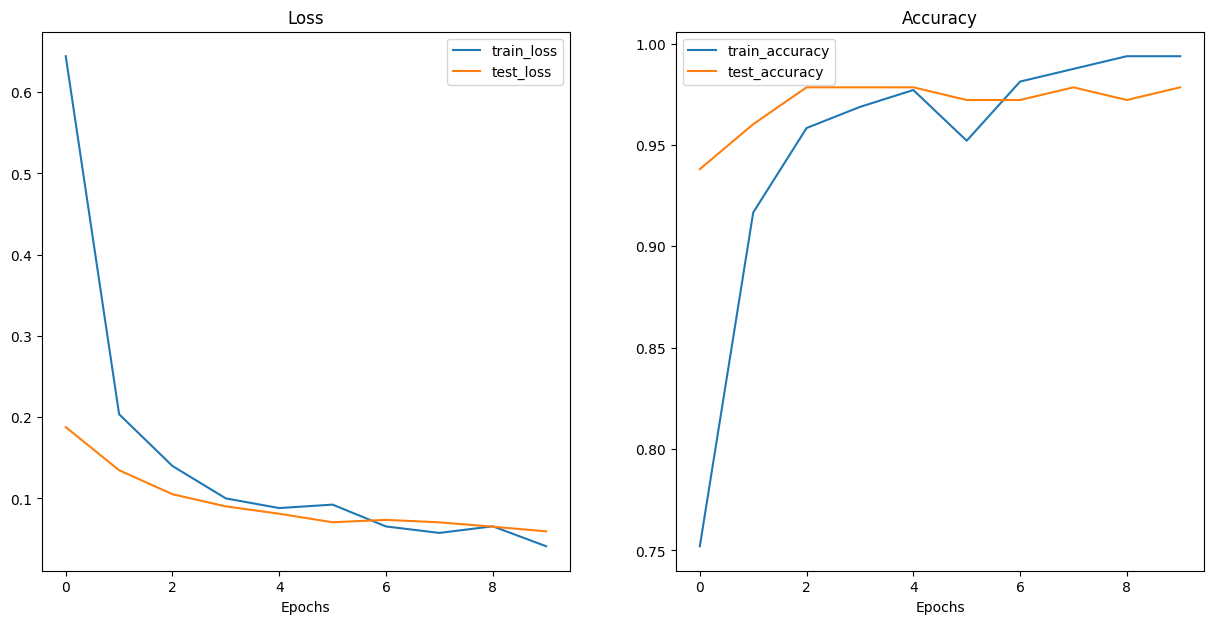

In [57]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

## 4. Try repeating the steps from excercise 3 but this time use the "`ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1`" pretrained weights from [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16).
* Note: ViT pretrained with SWAG weights has a minimum input image size of (384, 384), though this is accessible in the weights `.transforms()` method.

In [62]:
import torchvision
# 1. Get pretrained weights for ViT-Base
swag_vit_weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1 # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
swag_pretrained_vit = torchvision.models.vit_b_16(weights=swag_vit_weights)

# 3. Freeze the base parameters
for parameter in swag_pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
swag_pretrained_vit.heads = swag_pretrained_vit.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=768),
    nn.Linear(in_features=768, 
              out_features=len(class_names))
)
# swag_pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16_swag-9ac1b537.pth" to C:\Users\afana/.cache\torch\hub\checkpoints\vit_b_16_swag-9ac1b537.pth
100%|██████████| 331M/331M [00:03<00:00, 105MB/s]  


In [63]:
summary(model=swag_pretrained_vit, 
        input_size=(32, 3, 384, 384), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 384, 384]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 384, 384]    [32, 768, 24, 24]    (590,592)            False
├─Encoder (encoder)                                          [32, 577, 768]       [32, 577, 768]       443,136              False
│    └─Dropout (dropout)                                     [32, 577, 768]       [32, 577, 768]       --                   --
│    └─Sequential (layers)                                   [32, 577, 768]       [32, 577, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 577, 768]       [32, 577, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 577, 768]       [32, 

In [65]:
# 20%
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")
train_dir_20_percent = data_20_percent_path / "train"
test_dir_20_percent = data_20_percent_path / "test"

swag_vit_transforms = swag_vit_weights.transforms()  # get transforms from vit_weights
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent, 
                                                                                           test_dir=test_dir_20_percent,
                                                                                           transform=swag_vit_transforms, 
                                                                                           batch_size=32)

[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


In [66]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=swag_pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
swag_pretrained_vit_results = engine.train(model=swag_pretrained_vit,
                                      train_dataloader=train_dataloader_20_percent,
                                      test_dataloader=test_dataloader_20_percent,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

 10%|█         | 1/10 [00:33<05:02, 33.58s/it]

Epoch: 1 | train_loss: 0.4661 | train_acc: 0.9000 | test_loss: 0.0513 | test_acc: 1.0000


 20%|██        | 2/10 [01:06<04:23, 32.99s/it]

Epoch: 2 | train_loss: 0.0641 | train_acc: 0.9854 | test_loss: 0.0281 | test_acc: 1.0000


 30%|███       | 3/10 [01:38<03:47, 32.55s/it]

Epoch: 3 | train_loss: 0.0407 | train_acc: 0.9875 | test_loss: 0.0165 | test_acc: 1.0000


 40%|████      | 4/10 [02:09<03:13, 32.17s/it]

Epoch: 4 | train_loss: 0.0300 | train_acc: 0.9938 | test_loss: 0.0115 | test_acc: 1.0000


 50%|█████     | 5/10 [02:41<02:39, 31.90s/it]

Epoch: 5 | train_loss: 0.0241 | train_acc: 0.9938 | test_loss: 0.0098 | test_acc: 1.0000


 60%|██████    | 6/10 [03:12<02:06, 31.65s/it]

Epoch: 6 | train_loss: 0.0205 | train_acc: 0.9979 | test_loss: 0.0083 | test_acc: 1.0000


 70%|███████   | 7/10 [03:43<01:34, 31.56s/it]

Epoch: 7 | train_loss: 0.0168 | train_acc: 0.9979 | test_loss: 0.0070 | test_acc: 1.0000


 80%|████████  | 8/10 [04:15<01:03, 31.52s/it]

Epoch: 8 | train_loss: 0.0197 | train_acc: 0.9979 | test_loss: 0.0065 | test_acc: 1.0000


 90%|█████████ | 9/10 [04:46<00:31, 31.42s/it]

Epoch: 9 | train_loss: 0.0131 | train_acc: 1.0000 | test_loss: 0.0077 | test_acc: 1.0000


100%|██████████| 10/10 [05:17<00:00, 31.77s/it]

Epoch: 10 | train_loss: 0.0123 | train_acc: 0.9979 | test_loss: 0.0056 | test_acc: 1.0000


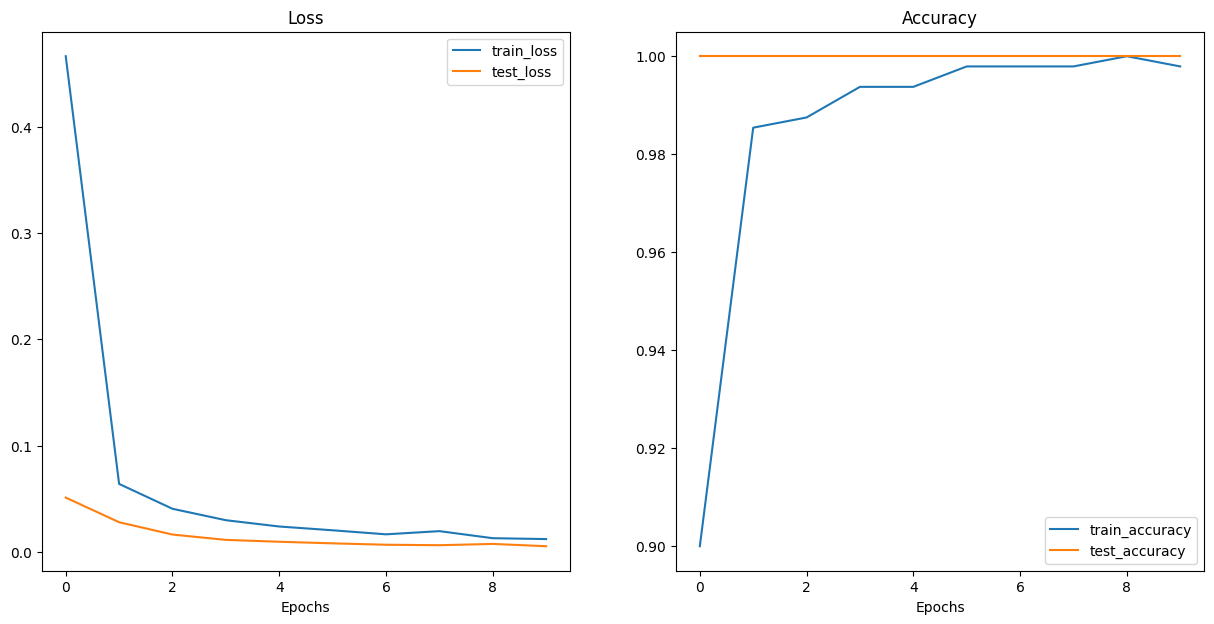

In [67]:
from helper_functions import plot_loss_curves

plot_loss_curves(swag_pretrained_vit_results)

# 5. Our custom ViT model architecture closely mimics that of the ViT paper, however, our training recipe misses a few things.
* Research some of the following topics from Table 3 in the ViT paper that we miss and write a sentence about each and how it might help with training:
    * **ImageNet-21k pretraining**
    * **Learning rate warmup**
    * **Learning rate decay**
    * **Gradient clipping**

In [ ]:
# TODO: your explanations of the above terms